# **Lunar Lander con Q-Learning**

### **1. Bibliotecas**

In [1]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

zsh:1: no matches found: gymnasium[box2d]


### **2. Jugando a mano**

A continuación se puede jugar un episodio del lunar lander. Se controlan los motores con el teclado. Notar que solo se puede realizar una acción a la vez (que es parte del problema), y que en esta implementación, izq toma precedencia sobre derecha, que toma precedencia sobre el motor principal.

In [32]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

import pygame
from pygame.locals import *

# Inicializar pygame (para el control con el teclado) y el ambiente
pygame.init()
env = gym.make('LunarLander-v2', render_mode='human')
env.reset()
pygame.display.set_caption('Lunar Lander')

clock = pygame.time.Clock()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True
            break

    keys = pygame.key.get_pressed()

    # Map keys to actions
    if keys[K_LEFT]:
        action = 3  # Fire left orientation engine
    elif keys[K_RIGHT]:
        action = 1 # Fire right orientation engine
    elif keys[K_UP]:
        action = 2  # Fire main engine
    else:
        action = 0  # Do nothing

    _, _, terminated, truncated, _ = env.step(action)
    env.render()
    clock.tick(10)

    if terminated or truncated:
        done = True

env.close()
pygame.quit()

## **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [2]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 15

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins)

In [34]:
# # Ejemplos
# print(discretize_state([0.0, 0.0, 0, 0, 0, 0, 1, 1], bins)) # En la zona de aterrizaje y quieto
# print(discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)) # Comenzando la partida, arriba y en el centro

## **4. Agentes y la interacción con el entorno**

Vamos a definir una interfaz para nuestro agente:

In [3]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Para un agente aleatorio, la implementación sería:

In [4]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        # No aprende
        pass

    def fin_episodio(self):
        # Nada que actualizar
        pass

Luego podemos definir una función para ejecutar un episodio con un agente dado:

In [37]:
def ejecutar_episodio(agente, aprender = True, render = None, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode=render).env

    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio()
    entorno.close()
    return recompensa_total

Podemos ejecutar este ambiente muchas veces y tomar métricas al respecto

In [5]:
agente = AgenteAleatorio()
recompensa_episodios = []

exitos = 0
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]

import numpy
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

NameError: name 'ejecutar_episodio' is not defined

### **5. Programando un agente que aprende**

### 5.1 Descripción del Agente de Aprendizaje por Refuerzo
#### 5.1.1 Selección de Acción (elegir_accion)
El agente selecciona una acción usando una política epsilon-greedy, que mezcla exploración y explotación:
* **Exploración**: Con probabilidad epsilon, el agente elige una acción aleatoria, lo que le permite explorar el espacio de acciones.
* **Explotación**: Si no se explora, el agente selecciona la acción con el valor Q más alto en el estado actual. Si el estado actual no está en la tabla Q, se inicializa con valores de acción igual a cero.

#### 5.1.2 Aprendizaje (aprender)
El agente actualiza su tabla Q utilizando la fórmula de Q-learning con la siguiente fórmula:
$$ \hat{Q}(s,a) \leftarrow r(s,a) + \gamma max_{a_{2}}\hat{Q}(\delta(s,a),a_{2}) $$

#### 5.1.3 Fin de Episodio (fin_episodio)
Al finalizar cada episodio, el valor de epsilon se reduce multiplicándose por el factor de decaimiento (*epsilon_decay*). Esto reduce gradualmente la cantidad de exploración y permite que el agente se enfoque más en la explotación de su política óptima.

### 5.2 Descripción del Agente de Aprendizaje por Refuerzo
Para entrenar al agente, ejecutamos 1000 episodios utilizando la fórmula estándar de Q-learning. Luego, para evaluar el rendimiento, ejecutamos otros 1000 episodios de explotación, midiendo la tasa de éxito, donde se considera exitoso un episodio si la recompensa total es mayor o igual a 200.

Durante la fase de aprendizaje, implementamos la política epsilon-greedy. Esta política consiste en explorar el entorno tomando una acción aleatoria con una probabilidad epsilon, mientras que el resto del tiempo se selecciona la mejor acción conocida. Al inicio del entrenamiento, el agente no tiene suficiente información sobre los resultados de las posibles acciones, por lo que es necesario realizar una exploración adecuada. A medida que el agente aprende, la probabilidad de exploración epsilon se va reduciendo mediante un factor de decaimiento llamado *epsilon_decay*, hasta alcanzar un valor mínimo *epsilon_min*. Esto permite que el agente explore al principio, pero luego se enfoque en explotar las acciones que llevan a mejores recompensas.

Durante la fase de explotación, ya no aplicamos la política epsilon-greedy dado que estamos interesados en medir el rendimiento del agente explotando únicamente las acciones que ha aprendido. Aplicar esta técnica de exploración durante la fase de explotación creemos que afectaría positivamente al agente.

In [6]:
class AgenteRL(Agente):
    def __init__(self, bins, max_accion, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995) -> None:
        super().__init__()
        self.gamma = gamma
        self.epsilon = epsilon  # Factor de exploración
        self.epsilon_min = epsilon_min  # Mínimo valor de epsilon para la política epsilon-greedy
        self.epsilon_decay = epsilon_decay  # Decaimiento de epsilon para disminuir exploración
        self.bins = bins
        self.max_accion = max_accion
        self.q_table = {}  # Tabla Q para almacenar los valores Q de los estados y acciones

    def _discretize_state(self, state):
        """Discretiza el estado continuo en una tupla de indices discretos"""

        state_disc = list()
        for i in range(len(state)):
            if i >= len(self.bins):
                state_disc.append(int(state[i]))
            else:
                state_disc.append(np.digitize(state[i], self.bins[i]))
        return tuple(state_disc)

    def elegir_accion(self, estado, max_accion, explorar=True) -> int:
        """Elige una acción usando la política epsilon-greedy."""

        estado = self._discretize_state(estado)

        if explorar and np.random.rand() < self.epsilon:  # Política epsilon-greedy
            return random.randint(0, max_accion - 1)  # Acción aleatoria
        else:
            if estado not in self.q_table:
                self.q_table[estado] = np.zeros(max_accion)  # Inicializa con ceros si no existe
            return np.argmax(self.q_table[estado])  # Acción óptima

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Actualiza la tabla Q usando la fórmula de Q-learning."""

        estado_anterior = self._discretize_state(estado_anterior)
        estado_siguiente = self._discretize_state(estado_siguiente)
        if estado_anterior not in self.q_table:
            self.q_table[estado_anterior] = np.zeros(self.max_accion)  # Inicializa con ceros si no existe
        if estado_siguiente not in self.q_table:
            self.q_table[estado_siguiente] = np.zeros(self.max_accion)  # Inicializa con ceros si no existe

        max_q_siguiente = np.max(self.q_table[estado_siguiente]) if estado_siguiente in self.q_table else 0
        q_valor_actual = recompensa + self.gamma * max_q_siguiente * (1 - terminado)
        self.q_table[estado_anterior][accion] = q_valor_actual

    def fin_episodio(self):
        """Reduce epsilon para disminuir la exploración en episodios futuros."""

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [7]:
def ejecutar_episodio(agente, aprender = True, render = None):
  entorno = gym.make('LunarLander-v2', render_mode=render).env
  recompensa_total = 0
  termino = False
  truncado = False
  estado_anterior, info = entorno.reset()

  while not termino and not truncado:
      # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
      accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)

      # Realizamos la accion
      estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)

      if (aprender):
          agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

      agente.fin_episodio()
      estado_anterior = estado_siguiente
      recompensa_total += recompensa
  entorno.close()
  return recompensa_total

Y ejecutar con el muchos episodios:

In [12]:
agente = AgenteRL(bins, env.action_space.n)
exitos_aprendiendo = 0
recompensa_episodios_aprendiendo = []
num_episodios_aprendiendo = 50000
for i in range(num_episodios_aprendiendo):
    recompensa = ejecutar_episodio(agente, aprender = True)

    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos_aprendiendo += 1

    recompensa_episodios_aprendiendo += [recompensa]
print(f"Tasa de éxito APRENDIENDO: {exitos_aprendiendo / num_episodios_aprendiendo}. Se obtuvo {np.mean(recompensa_episodios_aprendiendo)} de recompensa, en promedio")

recompensa_episodios_explotando = []
num_episodios_explotando = 1000
exitos_explotando = 0

for i in range(num_episodios_explotando):
    recompensa = ejecutar_episodio(agente, aprender = False)

    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos_explotando += 1

    recompensa_episodios_explotando += [recompensa]
print(f"Tasa de éxito EXPLOTANDO: {exitos_explotando / num_episodios_explotando}. Se obtuvo {np.mean(recompensa_episodios_explotando)} de recompensa, en promedio")


Tasa de éxito APRENDIENDO: 0.00664. Se obtuvo -128.06127706658077 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.006. Se obtuvo -110.28532381400699 de recompensa, en promedio


In [9]:
print(exitos)

14


## epsilon_min = 0.001
Tasa de éxito APRENDIENDO: 0.004. Se obtuvo -104.31968581897758 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.009. Se obtuvo -108.91409492368417 de recompensa, en promedio

## epsilon_min = 0.01
Tasa de éxito APRENDIENDO: 0.008. Se obtuvo -91.3373685148693 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.043. Se obtuvo -120.79008774000155 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.003. Se obtuvo -109.3484425306888 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.016. Se obtuvo -96.47607834783989 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.014. Se obtuvo -106.73023168865609 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.019. Se obtuvo -95.22858288161083 de recompensa, en promedio

## epsilon_min = 0.10
Tasa de éxito APRENDIENDO: 0.002. Se obtuvo -122.51146745371216 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.004. Se obtuvo -154.7603902252848 de recompensa, en promedio


## epsilon_decay = 0.9
Tasa de éxito APRENDIENDO: 0.006. Se obtuvo -107.76492953159527 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.008. Se obtuvo -113.79394720881875 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.005. Se obtuvo -110.27912561605888 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.008. Se obtuvo -128.09272901898802 de recompensa, en promedio

## epsilon_decay = 0.99
Tasa de éxito APRENDIENDO: 0.004. Se obtuvo -111.23436917136424 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.004. Se obtuvo -116.95376521841774 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.007. Se obtuvo -108.6750633761395 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.008. Se obtuvo -206.87386967964355 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.008. Se obtuvo -104.9135912746686 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.013. Se obtuvo -139.59356232723616 de recompensa, en promedio

## epsilon_decay = 0.999
Tasa de éxito APRENDIENDO: 0.007. Se obtuvo -110.29609377955552 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.007. Se obtuvo -224.1952773111115 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.007. Se obtuvo -107.53262581583502 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.011. Se obtuvo -116.29709060761846 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.003. Se obtuvo -113.10054070397375 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.008. Se obtuvo -124.49517197608107 de recompensa, en promedio

## epsilon_decay = 0.995
Tasa de éxito APRENDIENDO: 0.005. Se obtuvo -108.17598779750017 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.014. Se obtuvo -161.65881105440062 de recompensa, en promedio

Tasa de éxito APRENDIENDO: 0.005. Se obtuvo -110.53862659644496 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.011. Se obtuvo -86.40665071683235 de recompensa, en promedio

### Graficar recompensas para ambas fases

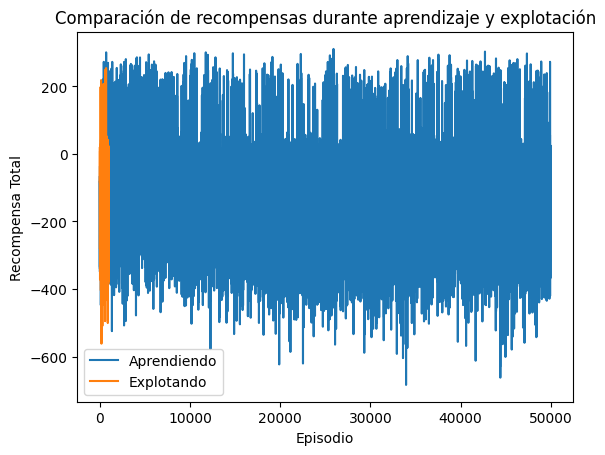

In [28]:
plt.plot(recompensa_episodios_aprendiendo, label='Aprendiendo')
plt.plot(recompensa_episodios_explotando, label='Explotando')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Comparación de recompensas durante aprendizaje y explotación')
plt.legend()
plt.show()

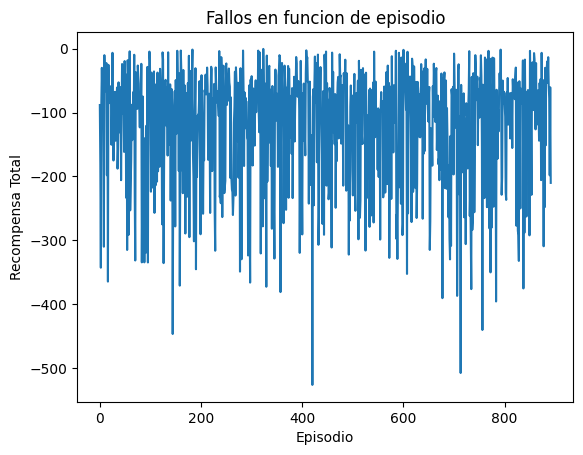

In [29]:
fallos = [recompensa for recompensa in recompensa_episodios_explotando if recompensa < 0]
# plt.plot(recompensa_episodios_aprendiendo, label='Aprendiendo')
# plt.plot(recompensa_episodios_explotando, label='Explotando')
plt.plot(fallos)
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Fallos en funcion de episodio')
# plt.legend()
plt.show()

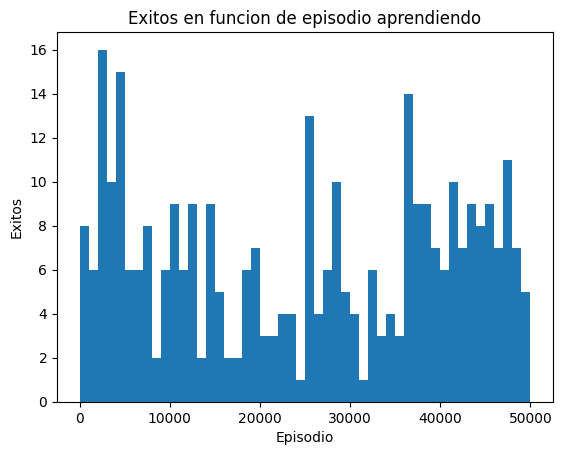

In [27]:
exitos = [1 if recompensa >= 200 else 0 for recompensa in recompensa_episodios_aprendiendo]

bins = 50  # Número de intervalos (puedes ajustarlo)
plt.hist(np.arange(len(exitos)), bins=bins, weights=exitos)
plt.xlabel('Episodio')
plt.ylabel('Exitos')
plt.title('Exitos en funcion de episodio aprendiendo')
# plt.legend()
plt.show()

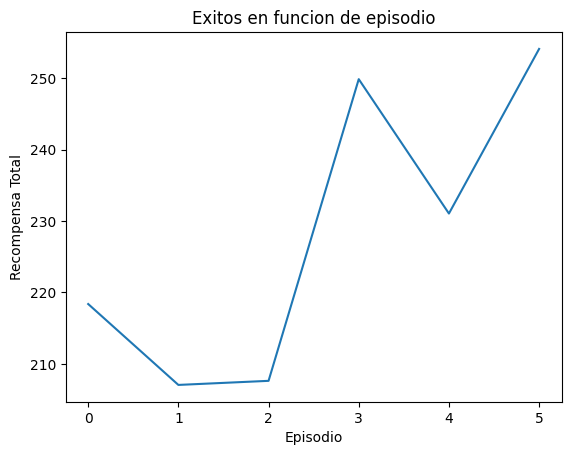

In [15]:
exitos = [recompensa for recompensa in recompensa_episodios_explotando if recompensa >= 200]
# plt.plot(recompensa_episodios_aprendiendo, label='Aprendiendo')
# plt.plot(recompensa_episodios_explotando, label='Explotando')
plt.plot(exitos)
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Exitos en funcion de episodio')
# plt.legend()
plt.show()

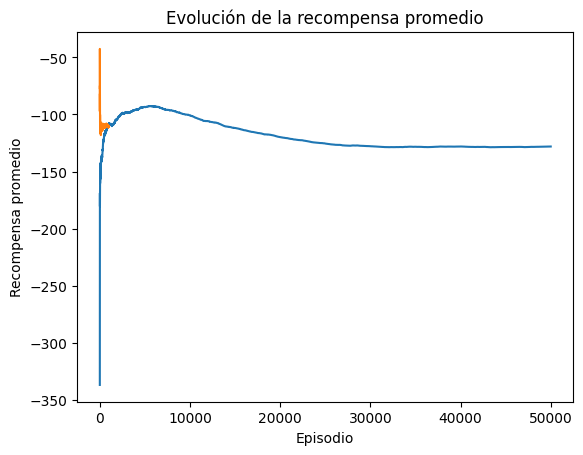

In [14]:
# recompensas promedio

recompensas_promedio_aprendiendo = [np.mean(recompensa_episodios_aprendiendo[:i+1]) for i in range(num_episodios_aprendiendo)]
recompensas_promedio_explotando = [np.mean(recompensa_episodios_explotando[:i+1]) for i in range(num_episodios_explotando)]
plt.plot(recompensas_promedio_aprendiendo, label='Aprendiendo')
plt.plot(recompensas_promedio_explotando, label='Explotando')
plt.title("Evolución de la recompensa promedio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa promedio")
plt.show()

¿La curva muestra una mejora constante o hay fluctuaciones considerables? Un aumento gradual es indicativo de que el agente está aprendiendo.

¿Hay estancamiento o decrecimiento en la recompensa promedio? Esto podría indicar que el agente llegó a un óptimo local o que la política de exploración ya no es efectiva.

¿Hubo algún cambio brusco en la curva? Si es así, intenta correlacionar esto con algún cambio en el comportamiento del agente, como cambios en la política de exploración o el aprendizaje.

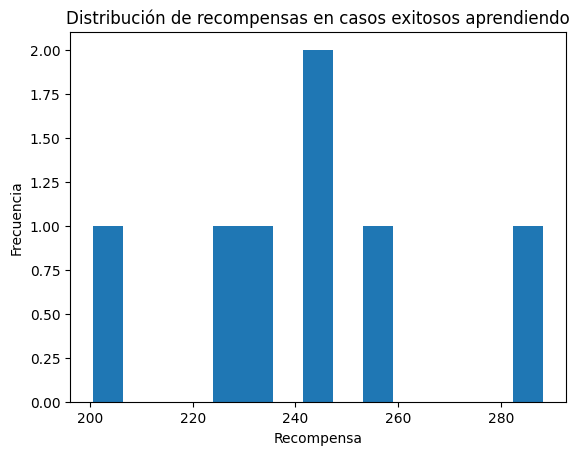

In [26]:
exitos = [recompensa for recompensa in recompensa_episodios_aprendiendo if recompensa >= 200]
plt.hist(exitos, bins=15)
plt.title("Distribución de recompensas en casos exitosos aprendiendo")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()

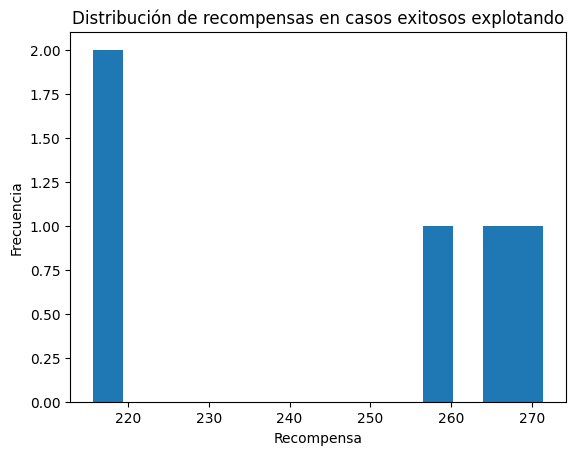

In [27]:
exitos = [recompensa for recompensa in recompensa_episodios_explotando if recompensa >= 200]
plt.hist(exitos, bins=15)
plt.title("Distribución de recompensas en casos exitosos explotando")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()

¿Cuántos episodios exitosos tuviste (aquellos con recompensa >= 200)?

¿Hay una concentración de recompensas en un rango muy alto (indicativo de un comportamiento muy optimizado) o la mayoría de los éxitos son marginales (justo por encima de 200)?

¿La cantidad de éxitos aumenta hacia el final de los episodios o es constante?


hay que ver cuantos hay con >= 200 y en que episodios pasaron

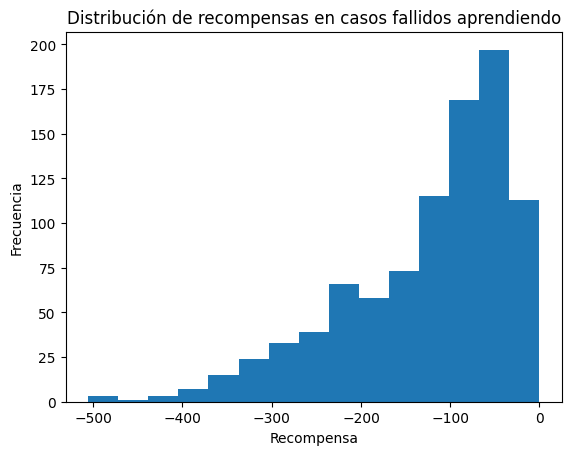

In [20]:
# Distribución de recompensas en casos fallidos: Representar las recompensas en episodios donde el agente falló.

fallos = [recompensa for recompensa in recompensa_episodios_aprendiendo if recompensa < 0]
plt.hist(fallos, bins=15)
plt.title("Distribución de recompensas en casos fallidos aprendiendo")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()

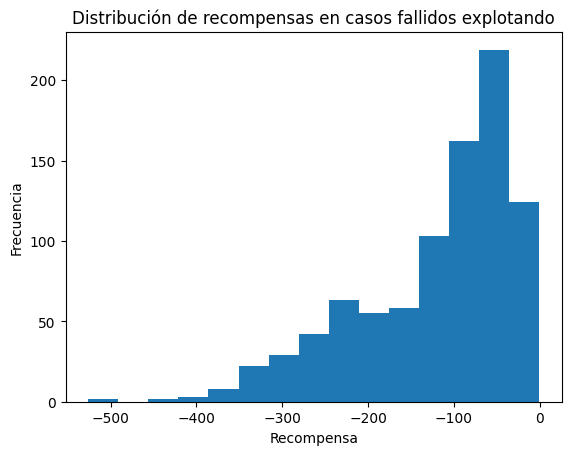

In [22]:
fallos = [recompensa for recompensa in recompensa_episodios_explotando if recompensa < 0]
plt.hist(fallos, bins=15)
plt.title("Distribución de recompensas en casos fallidos explotando")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()

¿Los fallos son más frecuentes al inicio del entrenamiento (indicando que el agente estaba aprendiendo) o se mantienen constantes hasta el final?

Si los fallos siguen ocurriendo hacia el final, ¿hay estados particulares que siempre llevan al fracaso?

Examina qué decisiones tomó el agente en esos episodios fallidos. Puede ser que ciertos estados críticos o transiciones estén llevando sistemáticamente a un mal desempeño.

hay que ver cuantos hay con < 200 y en que episodios pasaron

Analizar los resultados de la ejecución anterior, incluyendo:
 * Un análisis de los parámetros utilizados en el algoritmo (aprendizaje, política de exploración)
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación)
 * Un análisis de la evolución de la recompensa promedio
 * Un análisis de los casos de éxito
 * Un análisis de los casos en el que el agente falla
 * Qué limitante del agente de RL les parece que afecta más negativamente su desempeño. Cómo lo mejorarían? 

In [9]:
# Analizar los resultados aqui
